In [45]:
import math

## Setup

In [46]:
class Value:
    def __init__(self, data, _children=(), _op='', label='', grad=0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data+other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data*other.data, (self, other), '*')
        return out
    def tanh(self):
        x = self.data
        out = Value((math.exp(2*x)-1)/(math.exp(2*x)+1),(self,),'tanh')
        return out

In [47]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (
            n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

## Example 1 (Manual Backpropagation)

In [48]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
d = Value(20, label='d')
e = a*c
e.label = 'e'
f = b*d
f.label = 'f'
L = e+f
L.label = 'L'

In [49]:
L.grad = 1
f.grad = 1
e.grad = 1
a.grad = 10
b.grad = 20
c.grad = 2
d.grad = -3

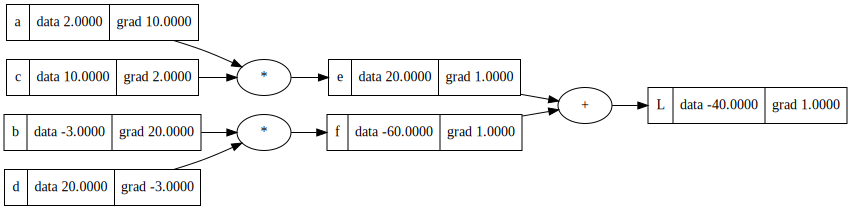

In [50]:
draw_dot(L)

## Example 2 (Neural Networks)

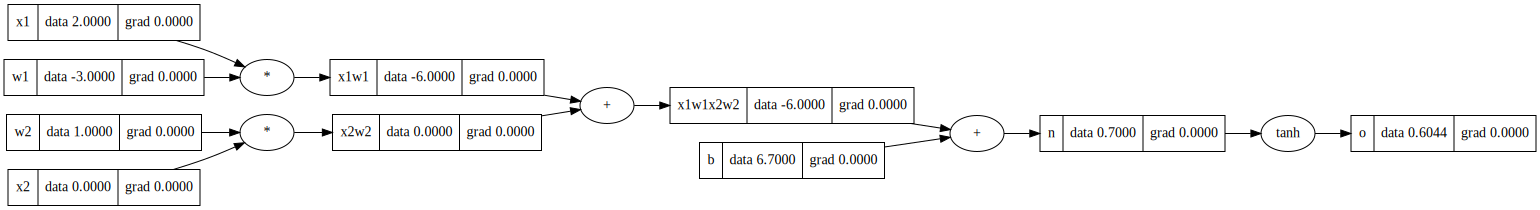

In [51]:
x1 = Value(2.0,label ='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7,label='b')
x1w1 = x1*w1;x1w1.label='x1w1'
x2w2 = x2*w2;x2w2.label='x2w2'
x1w1x2w2 = x1w1+x2w2;x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b;n.label='n'
o = n.tanh();o.label='o'
draw_dot(o)
